# Project description

At summer July-August 2023, I was hired by Ishaan to create a model that could predict the amount of left-over within a wide variety of food types by looking at the photo, it had to be as much accurate as possible and work for different angles, light reflections and recipe choices.

The approach made to accomplish this task goes as follows:

# U-Net

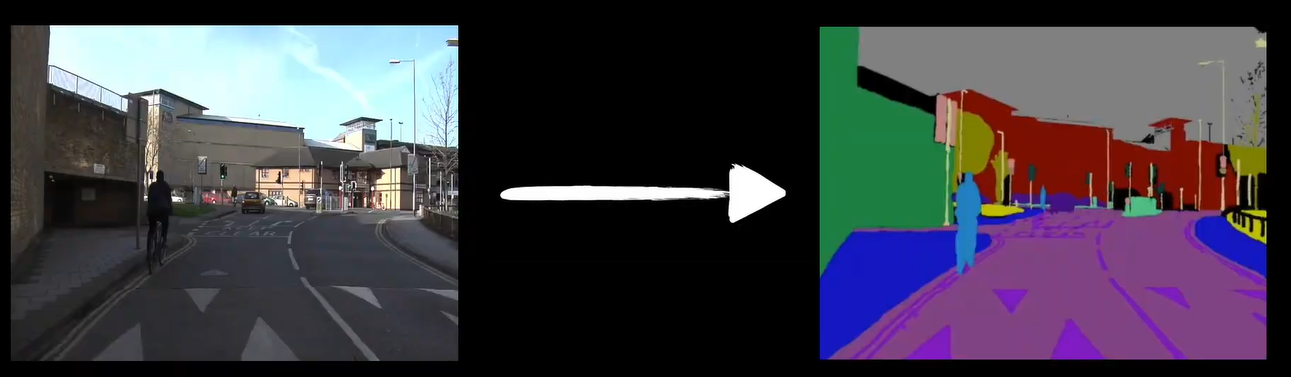

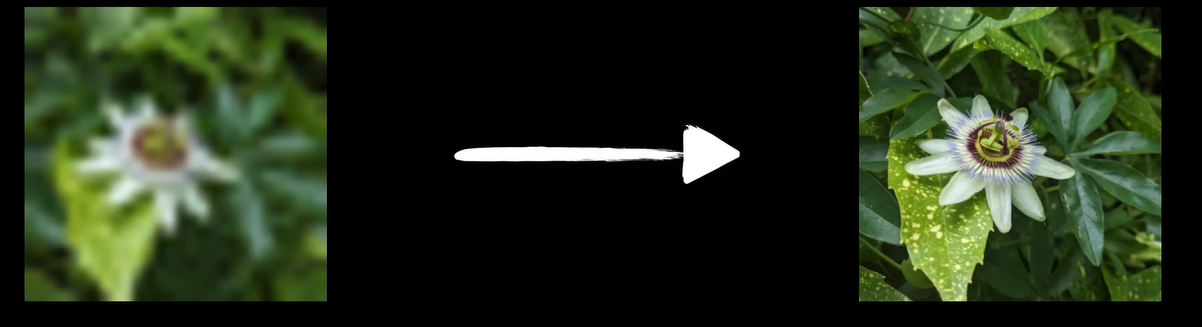

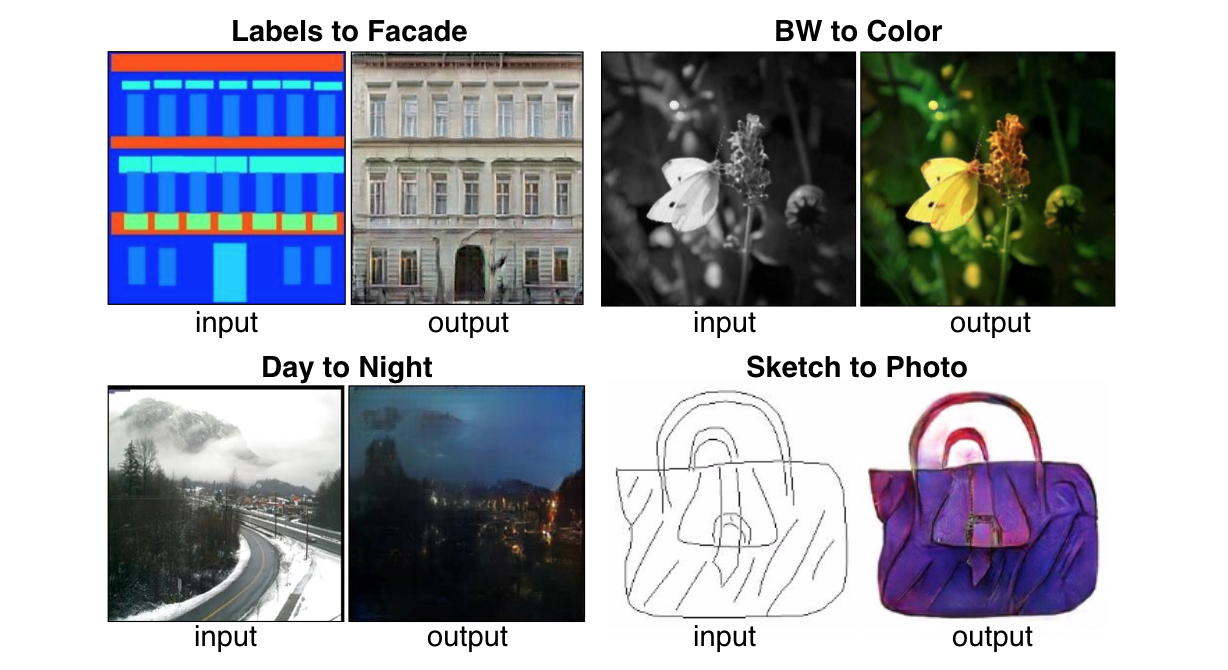

The U-Net is a popular convolutional neural network (CNN) architecture that was originally designed for biomedical image segmentation. However, its architecture and concepts have found applications in various other domains beyond medical imaging. Here are some applications of the U-Net:

* **Image Segmentation:** The U-Net was initially developed for segmenting biomedical images, such as medical scans, to identify and separate different structures or regions of interest within the images.

* **Image-to-Image Translation:** U-Net has been utilized for tasks like image-to-image translation, where it can learn to map images from one domain to another. For example, converting grayscale images to color images or transforming images in one artistic style to another.

* **Object Detection:** U-Net has been applied in object detection tasks, particularly for small objects or instances that are difficult to detect using traditional methods. By combining the U-Net architecture with object detection techniques, it can improve the localization and segmentation of objects in an image.

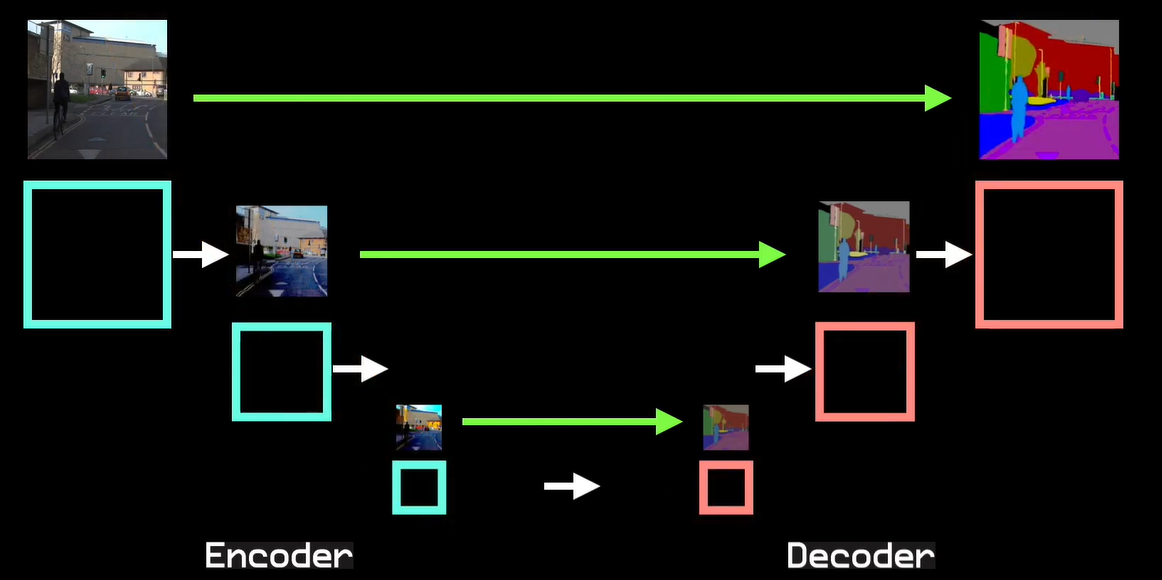

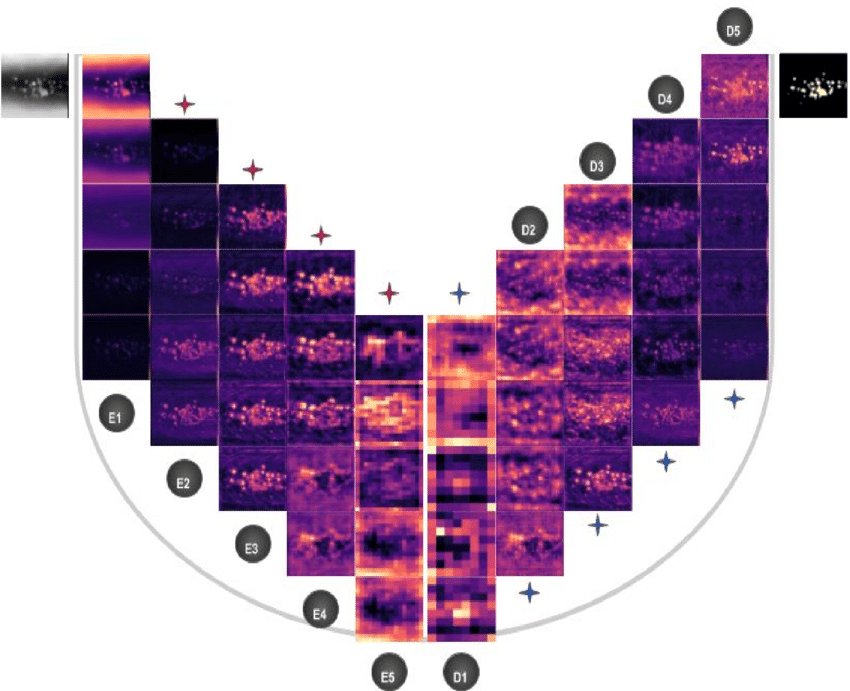

<font color='blue'>**The encoder part of the U-Net**</font> architecture performs a series of operations to extract features from the input image and gradually reduce its spatial dimensions. Let's break down the encoder part step by step:

* **Input Image:** The encoder takes an input image as its initial input. The input image is typically a 2D array or a tensor representing the pixel values of the image.

* **Convolutional Layers:** The U-Net starts with a series of convolutional layers. Each convolutional layer applies a set of learnable filters (kernels) to the input image, performing element-wise multiplications and summations to produce feature maps. These convolutional layers capture local patterns and low-level features.

* **Activation Function:** After each convolutional layer, an activation function is applied element-wise to the feature maps. The activation function introduces non-linearity into the network, allowing it to model complex relationships and capture more abstract features.

* **Downsampling:** The U-Net performs downsampling or pooling operations, typically using max pooling or strided convolutions. These operations reduce the spatial dimensions of the feature maps while increasing the number of channels (depth). Downsampling helps in capturing more global context and reducing computational complexity.

* <font color = 'green'>**Skip Connections:** At each downsampling step, the U-Net establishes skip connections between the downsampling path and the corresponding upsampling path. These skip connections preserve high-resolution feature maps from the encoder and pass them to the decoder, enabling the decoder to access fine-grained details during upsampling

* <font color = 'green'>**Feature Concatenation:** The feature maps from the skip connections are concatenated with the upsampled feature maps in the decoder path. This concatenation allows the decoder to combine low-level features from the encoder with high-level features learned during upsampling, enabling the network to recover fine details while maintaining global context.

> To combine the feature maps from the encoder with the feature maps in the decoder, concatenation is performed along the channel dimension. Specifically, the feature maps from the encoder with dimensions H × W × C are concatenated with the feature maps from the decoder with dimensions h × w × c. The concatenation operation results in combined feature maps with dimensions H × W × (C + c).

By repeating these steps, the encoder progressively reduces the spatial dimensions of the input image while capturing and abstracting higher-level features. This hierarchical representation enables the U-Net to learn and retain both local details and global context, which is crucial for accurate segmentation or other image analysis tasks.

<font color='pink'>**The decoder part of the U-Net**</font> network is responsible for upsampling the feature maps and gradually recovering the spatial resolution of the input image. It takes the concatenated feature maps from the encoder and performs a series of operations to reconstruct the high-resolution output. Here's a breakdown of what the decoder part does:

* **Concatenation:** As mentioned earlier, the decoder receives the concatenated feature maps from the corresponding encoder layers via skip connections. These concatenated feature maps contain both high-level semantic information from the encoder and low-level details from the encoder's earlier layers.

* **Upsampling:** The decoder starts by performing upsampling operations to increase the spatial dimensions of the feature maps. Upsampling can be done through techniques like transposed convolutions (also known as deconvolutions or fractionally strided convolutions) or nearest-neighbor interpolation followed by a convolution. The aim is to gradually recover the original resolution of the input image.

* **Convolutional Layers:** Following the upsampling step, the decoder applies a series of convolutional layers to the upsampled feature maps. These convolutional layers refine the features, capture more intricate patterns, and enhance the representation as the spatial resolution increases.

* **Skip Connection Concatenation:** At each upsampling step, the decoder performs concatenation between the upsampled feature maps and the corresponding feature maps from the encoder via skip connections. This allows the decoder to incorporate low-level details and fine-grained information from the encoder, which aids in reconstructing the high-resolution output with enhanced details.

* **Convolutional Operations:** After concatenation, additional convolutional layers may be applied to further refine the features and reduce the number of channels if necessary. These convolutional operations help in learning more abstract representations and preparing the feature maps for the final output.

* **Output Layer:** Finally, the decoder produces the output of the U-Net network. The specific task being performed determines the nature of the output layer. For example, in image segmentation tasks, the output layer may employ a pixel-wise classification layer, whereas in super-resolution tasks, it may use a regression layer to generate the high-resolution output image.

By combining upsampling, concatenation with skip connections, and convolutional operations, the decoder effectively reconstructs the high-resolution output from the low-resolution input, while leveraging information from multiple scales to capture both local details and global context.

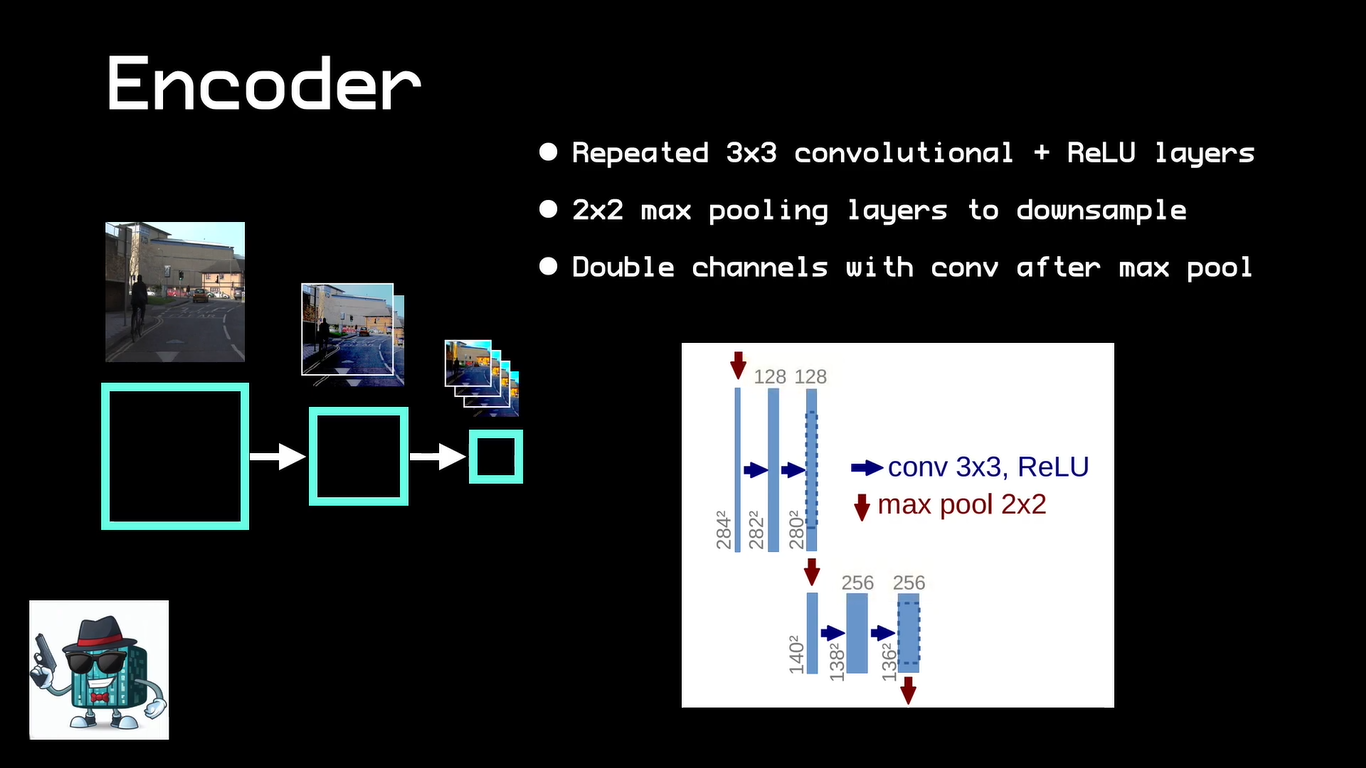

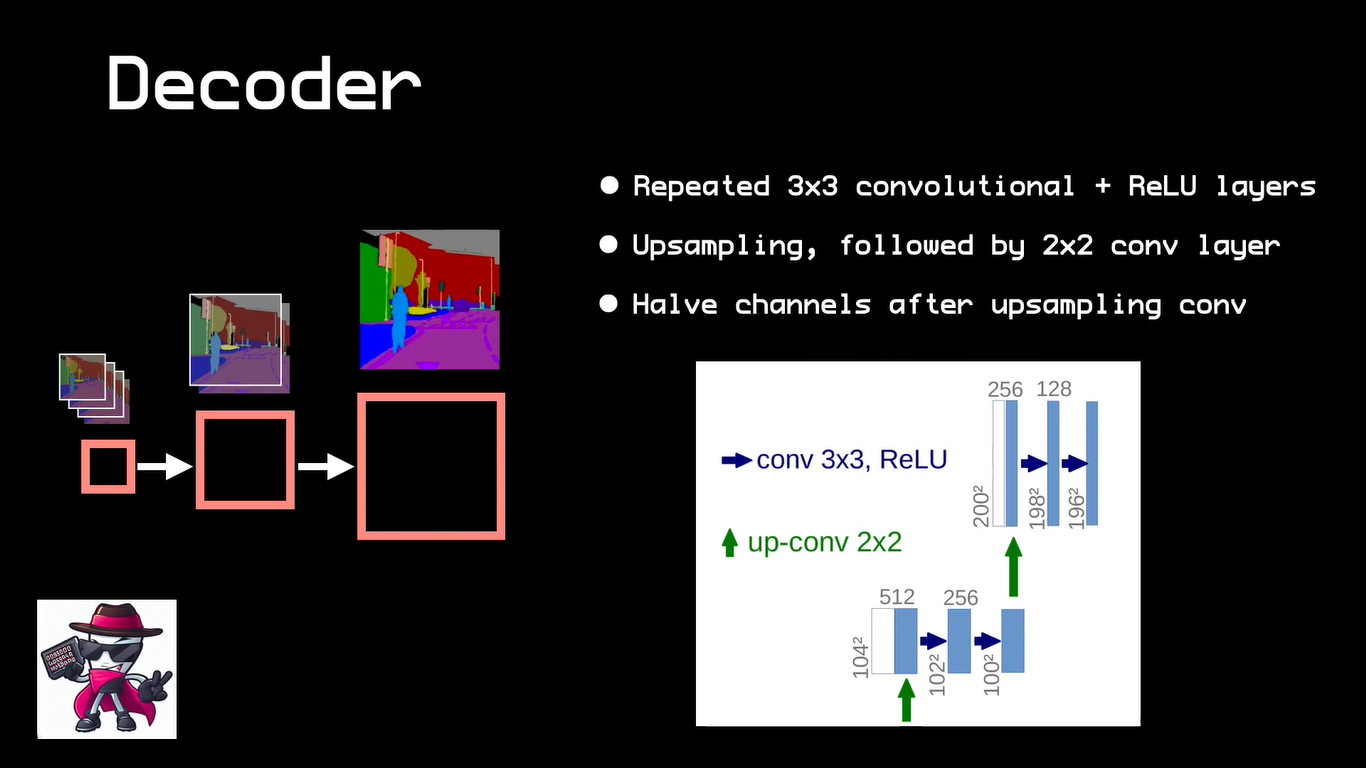

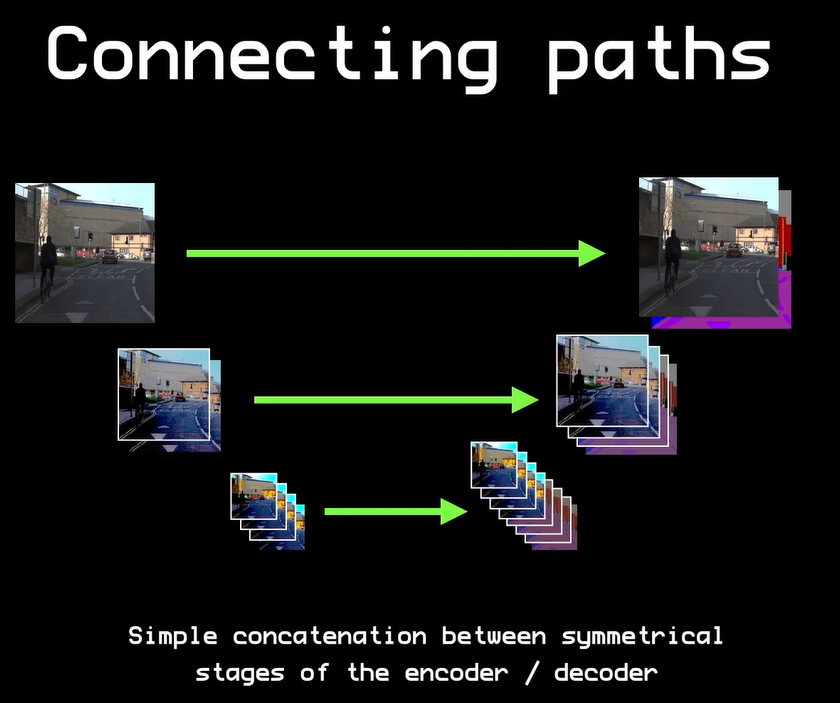

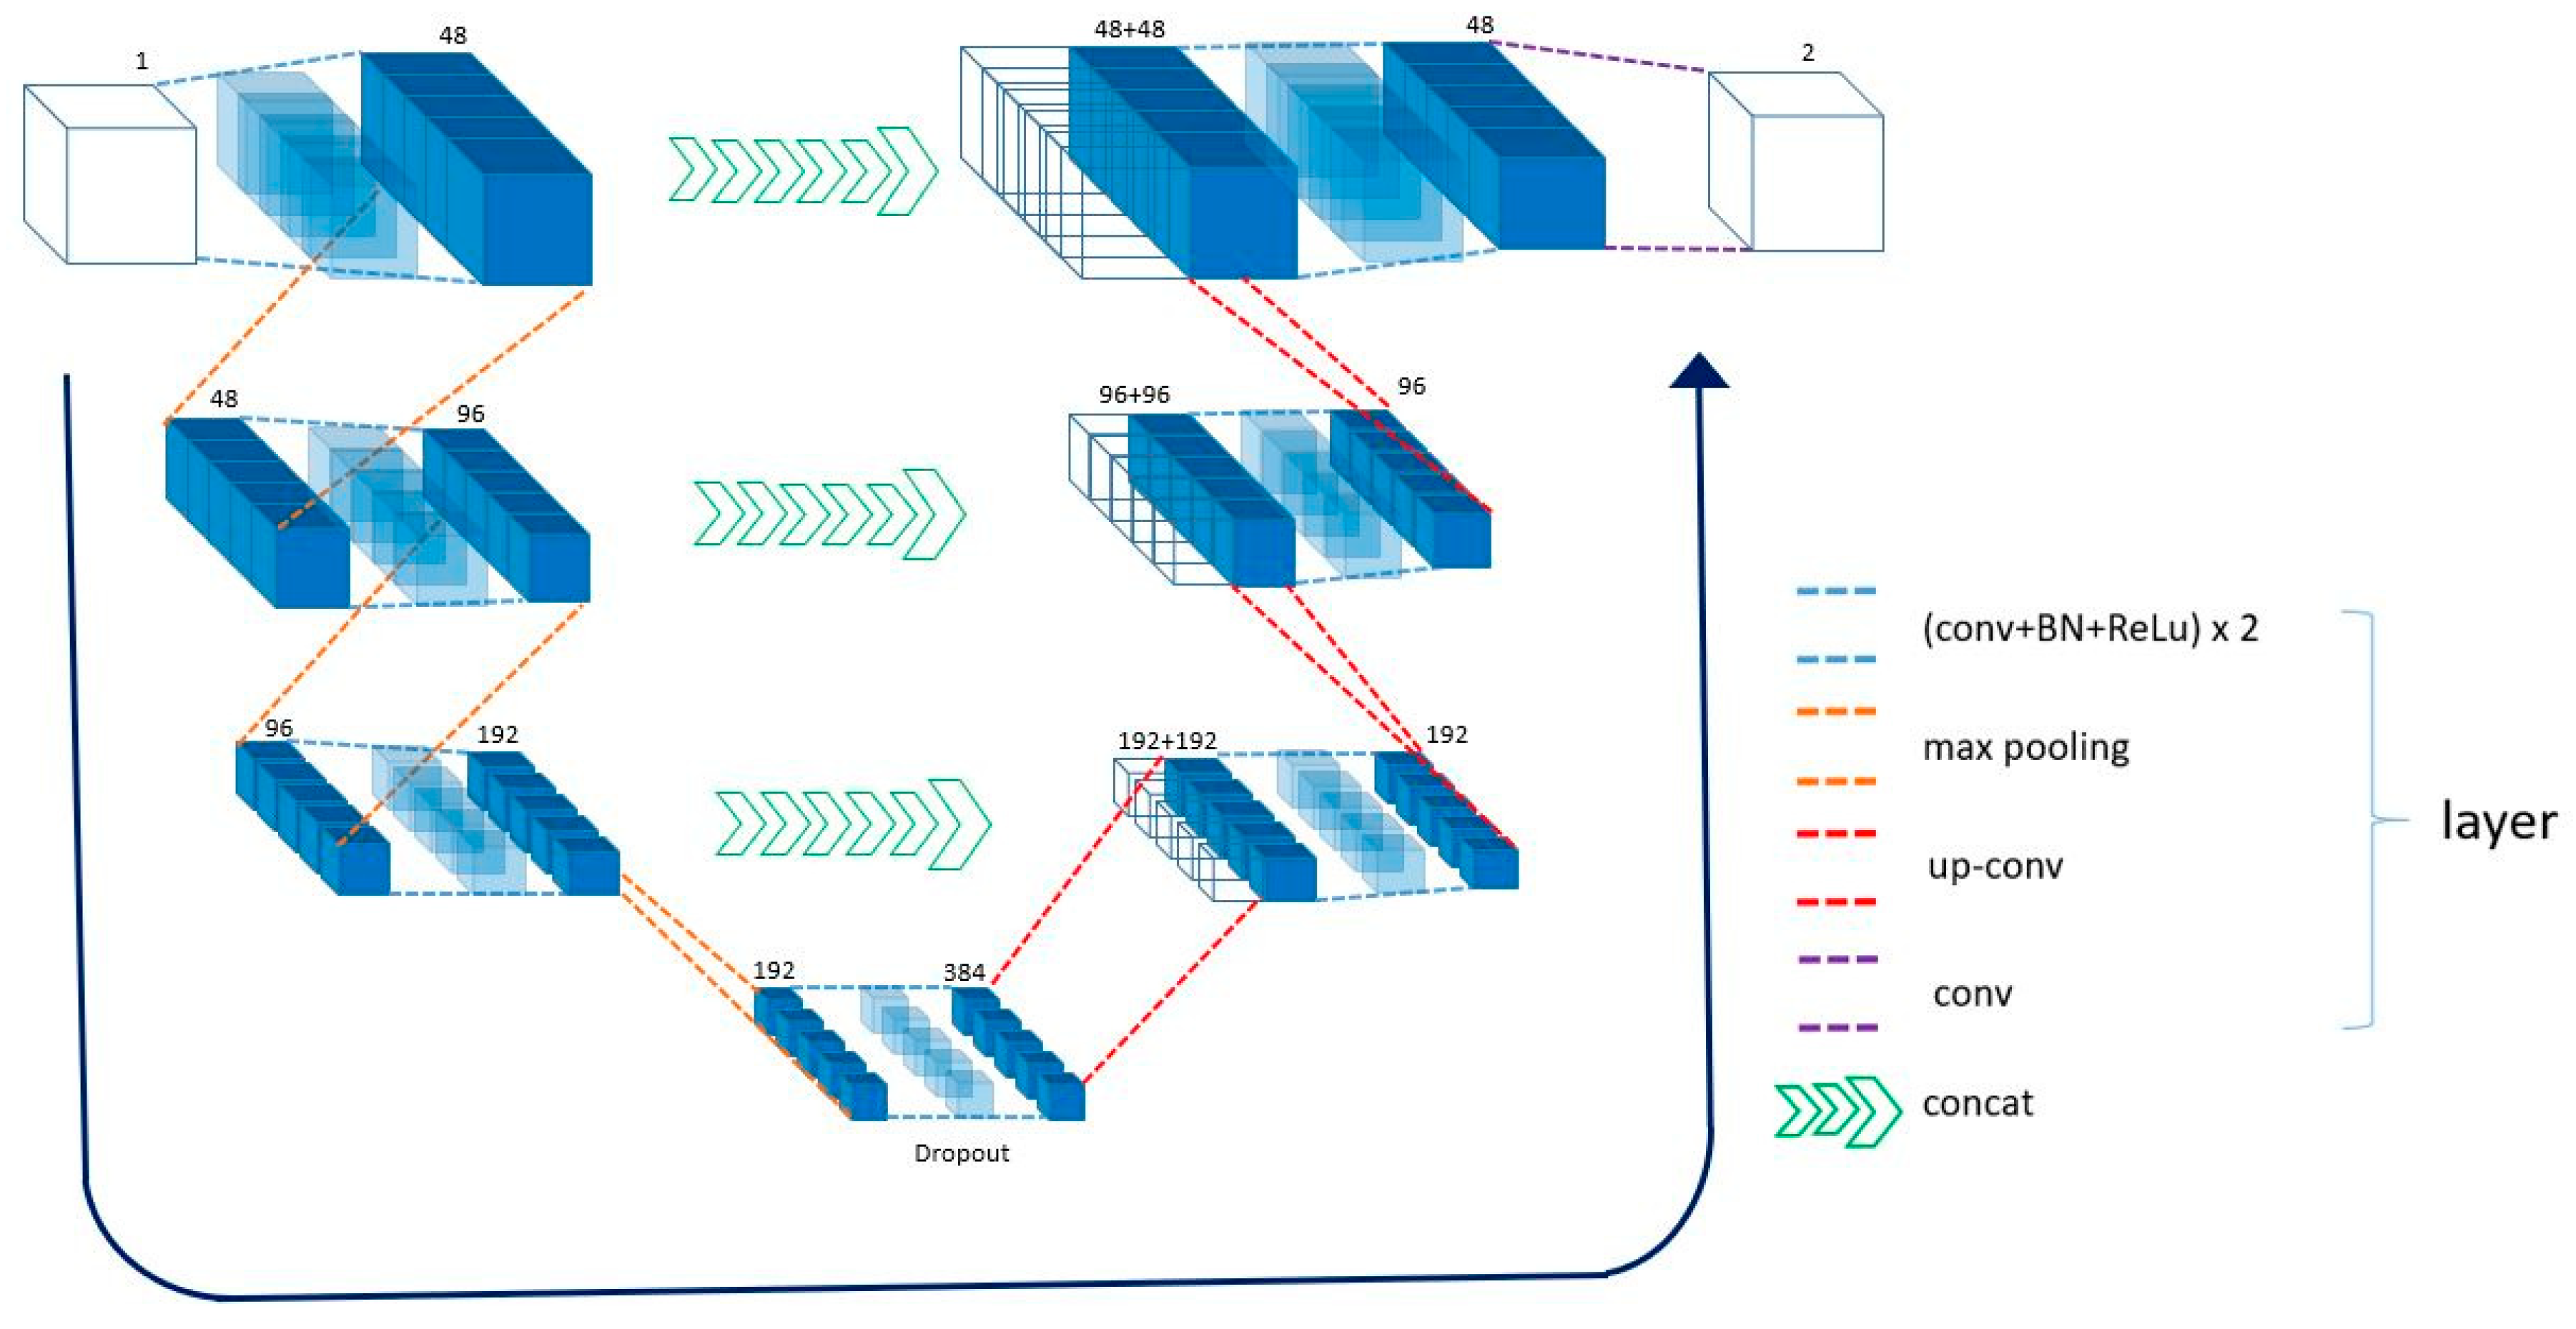

# Implementation of the U-Net

# Dataset specificatons

The dataset used for this project was published by [K SCOTT MADER on Kaggle](https://www.kaggle.com/datasets/kmader/food41?resource=download)

> The dataset contains a number of different subsets of the full food-101 data. The idea is to make a more exciting simple training set for image analysis than CIFAR10 or MNIST. **There are 101 categories represented, with n=1000 images, that have a resolution of 384x384x3 (RGB, uint8)**

The first step is to create the masks folder, split both original images and mask images into train/valid with a 70% - 30% ratio, resize the images at a 2 potency, choose HSV color range that creates the corresponding binary mask of the Region of Interest (ROI) and repeat for all images on the dataset.


In [1]:
import os
import matplotlib.pyplot as plt
import colorsys
import numpy as np
import cv2
from google.colab.patches import cv2_imshow
from PIL import Image
import glob
import tensorflow as tf
import re
import shutil
from glob import glob
import random

batch_size = 4 # 4 from 12 RAM, check todo list
lr = 0.0001
epochs = 6

height = 512
width = 512

def delete_images_in_directory(directory_path):
    for filename in os.listdir(directory_path):
        file_path = os.path.join(directory_path, filename)
        if os.path.isfile(file_path) and any(filename.lower().endswith(extension) for extension in ['.jpg', '.jpeg', '.png', '.gif']):
            os.remove(file_path)

def create_mask_folder(path, array1, array2, display):
  # Directory
  aux_path = re.sub(os.path.basename(os.path.normpath(path)), '', path) # /content/drive/MyDrive/images/
  directory = os.path.basename(os.path.normpath(path)) + '_masks' # applepie_masks

  # Path
  new_path = os.path.join(aux_path, directory) # /content/drive/MyDrive/images/applepie_masks
  # Create the folder if it doesn't exist
  if not os.path.exists(new_path):
    os.makedirs(new_path)
  else:
    delete_images_in_directory(new_path)
    os.rmdir(new_path)
    os.makedirs(new_path)

  # read input image
  for filename in os.listdir(path):
    img = cv2.imread(os.path.join(path,filename))
    img = cv2.resize(img, (512, 512))
    cv2.imwrite(os.path.join(path, filename), img)

    # Convert BGR to HSV
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    if display is True:
      # Display the image
        cv2_imshow(img)

    # define range of blue color in HSV
    lower_color = np.array(array1) # [15,50,180]
    upper_color = np.array(array2) # [40,255,255]

    # Create a mask. Threshold the HSV image to get only yellow colors
    mask = cv2.inRange(hsv, lower_color, upper_color)

    if display is True:
      # Display the mask image
      cv2_imshow(mask)

    mask_path = os.path.join(new_path, filename.replace('.jpg','') + '_mask.jpg')
    cv2.imwrite(mask_path, mask)

In [2]:
"""
min_of_all_colors = np.full((10, 10, 3), (90, 0, 0), dtype=np.uint8) / 255.0
max_of_all_colors = np.full((10, 10, 3), (225, 185, 110), dtype=np.uint8) / 255.0
plt.subplot(1, 2, 1)
plt.imshow((min_of_all_colors))
plt.subplot(1, 2, 2)
plt.imshow((max_of_all_colors))
plt.show()
"""

'\nmin_of_all_colors = np.full((10, 10, 3), (90, 0, 0), dtype=np.uint8) / 255.0\nmax_of_all_colors = np.full((10, 10, 3), (225, 185, 110), dtype=np.uint8) / 255.0\nplt.subplot(1, 2, 1)\nplt.imshow((min_of_all_colors))\nplt.subplot(1, 2, 2)\nplt.imshow((max_of_all_colors))\nplt.show()\n'

# HSV color range

In order to easily choose a color palette for an specific type of food, we can define the following methods to convert RGB values to HSV at 255% saturation and value, and sort them as tuples

In [3]:
import colorsys

def rgb_to_expanded_hsv(r, g, b):
    # Normalize the RGB values to the range [0, 1]
    r_normalized, g_normalized, b_normalized = r / 255, g / 255, b / 255

    # Convert RGB to HSV
    h, s, v = colorsys.rgb_to_hsv(r_normalized, g_normalized, b_normalized)

    # Expand the HSV values to the desired ranges
    h_expanded = int(h * 179)
    s_expanded = int(s * 255)
    v_expanded = int(v * 255)

    return h_expanded, s_expanded, v_expanded

r, g, b = 90, 0, 0
h, s, v = rgb_to_expanded_hsv(r, g, b)
hsv_min = (h,s,v)


r, g, b = 225, 185, 110
h, s, v = rgb_to_expanded_hsv(r, g, b)
hsv_max = (h,s,v)


In [4]:
def rearrange_if_greater(h1_s1_v1, h2_s2_v2):
    h1, s1, v1 = h1_s1_v1
    h2, s2, v2 = h2_s2_v2

    if h1 > h2:
        h1, h2 = h2, h1
    if s1 > s2:
        s1, s2 = s2, s1
    if v1 > v2:
        v1, v2 = v2, v1

    return (h1, s1, v1), (h2, s2, v2)

hsv_min, hsv_max = rearrange_if_greater(hsv_min, hsv_max)
print(hsv_min)
print(hsv_max)


(0, 130, 90)
(19, 255, 225)


In [5]:
# create_mask_folder('/content/drive/MyDrive/images/apple_pie/train', [0, 70, 70], [100, 210, 210], False)
# create_mask_folder('/content/drive/MyDrive/images/apple_pie/valid', [0, 70, 70], [100, 210, 210], False)
# create_mask_folder('/content/drive/MyDrive/images/chicken_wings', list(hsv_min), list(hsv_max), False)

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Model saving

Saving the model as a .h5 file (HDF5 format) is important for creating checkpoints of model's architecture, weights, optimizer state, and any other necessary configuration in a single file. This way, we can easily load the model later without having to retrain it from scratch. It ensures the model's persistence, making it convenient for reuse and sharing.

Once we have trained and optimized your model, saving it as a .h5 file allows to deploy it easily in various environments. We can load the model into different applications, platforms, or frameworks for inference without needing to rewrite the model architecture and retrain it.

Transfer Learning is also possible by saving models in the .h5 format, we can leverage pre-trained models in various projects. For instance, we can use a pre-trained model as a starting point for a new task and fine-tune it on your specific data. This practice is known as transfer learning and is a common technique in deep learning.

In [7]:
dataset_path = '/content/drive/MyDrive/images'

files_dir = '/content/drive/MyDrive/Unet'
model_file = os.path.join(files_dir, "unet.h5")
log_file = os.path.join(files_dir, "log.csv")

In [8]:
from sys import call_tracing
def conv_block(inputs, num_filters):
  x = tf.keras.layers.Conv2D(num_filters, 3, padding="same")(inputs)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.LeakyReLU(alpha=0.01)(x)

  x = tf.keras.layers.Conv2D(num_filters, 3, padding="same")(x)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.LeakyReLU(alpha=0.01)(x)

  return x

In [9]:
def encoder_block(inputs, num_filters):
  x = conv_block(inputs, num_filters)
  p = tf.keras.layers.MaxPool2D((2,2))(x)
  return x, p

In [10]:
def decoder_block(inputs, skip, num_filters):
  x = tf.keras.layers.Conv2DTranspose(num_filters, (2,2), strides=2, padding="same")(inputs)
  x = tf.keras.layers.Concatenate()([x, skip])
  x = conv_block(x, num_filters)
  return x

In [11]:
def build_unet(input_shape):
  inputs = tf.keras.layers.Input(input_shape)

  # Encoder
  s1, p1 = encoder_block(inputs, 64) # 500 x 500
  s2, p2 = encoder_block(p1, 128) # 250 x 250
  s3, p3 = encoder_block(p2, 256) # 125 x 125
  s4, p4 = encoder_block(p3, 512) # 62 x 62

  # Bridge
  b1 = conv_block(p4, 1024) # 31 x 31

  # Decoder
  d1 = decoder_block(b1, s4, 512) # 31 x 31
  d2 = decoder_block(d1, s3, 256)
  d3 = decoder_block(d2, s2, 128)
  d4 = decoder_block(d3, s1, 64)

  outputs = tf.keras.layers.Conv2D(1, 1, padding="same", activation="sigmoid")(d4)
  model = tf.keras.models.Model(inputs, outputs, name="UNET")
  return model

In [12]:
def load_data(path, name):
  train_x = sorted(glob(os.path.join(path, name, "train", "*")))
  valid_x = sorted(glob(os.path.join(path, name, "valid", "*")))

  train_y = sorted(glob(os.path.join(path, name, "train_masks", "*")))
  valid_y = sorted(glob(os.path.join(path, name, "valid_masks", "*")))

  return (train_x, train_y), (valid_x, valid_y)

In [13]:
def read_image(path):
  path = path.decode()
  x = cv2.imread(path, cv2.IMREAD_COLOR)
  x = x / 255.0
  return x

In [14]:
def read_mask(path):
  path = path.decode()
  x = cv2.imread(path, cv2.IMREAD_GRAYSCALE )
  x = x / 255.0
  x = np.expand_dims(x, axis=-1)
  return x

In [15]:
def tf_parse(x, y):
  def _parse(x, y):
    x = read_image(x)
    y = read_mask(y)
    return x, y
  x, y = tf.numpy_function(_parse, [x,y], [tf.float64, tf.float64])
  x.set_shape([height, width, 3])
  y.set_shape([height, width, 1])
  return x, y

In [16]:
def tf_dataset(x, y, batch=8):
  dataset = tf.data.Dataset.from_tensor_slices((x,y))
  dataset = dataset.map(tf_parse, num_parallel_calls=tf.data.AUTOTUNE)
  dataset = dataset.batch(batch)
  dataset = dataset.prefetch(tf.data.AUTOTUNE)
  return dataset

In [17]:
(train_x, train_y), (valid_x, valid_y) = load_data(dataset_path, 'apple_pie')

In [18]:
print(f"Train: {len(train_x)} - {len(train_y)}")
print(f"Valid: {len(valid_x)} - {len(valid_y)}")

Train: 150 - 150
Valid: 50 - 50


In [19]:
train_dataset = tf_dataset(train_x, train_y, batch=batch_size)
valid_dataset = tf_dataset(valid_x, valid_y, batch=batch_size)

In [20]:
input_shape = (height, width, 3)
model = build_unet(input_shape)
# model.summary()

In [21]:
opt = tf.keras.optimizers.Adam(lr)
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=['acc'])

In [22]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(model_file, verbose=1, save_best_only=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=4),
    tf.keras.callbacks.CSVLogger(log_file),
    tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=20, restore_best_weights=False)
]

In [23]:
# model.fit(train_dataset, validation_data=valid_dataset, epochs=epochs, callbacks=callbacks) # 0.7 acc, 0.48 val acc

In [45]:
from PIL import Image

def make_prediction(path):
  image = Image.open(path)
  image = image.resize((512, 512))  # Resize the image to match the model's input shape
  input_data = np.array(image)  # Convert the image to a NumPy array
  input_data = np.expand_dims(input_data, axis=0)  # Add a batch dimension
  predicted_mask = model.predict(input_data)
  return predicted_mask, input_data

predicted_mask, input_data = make_prediction(valid_x[26])

1/1 [==============================] - 11s 11s/step


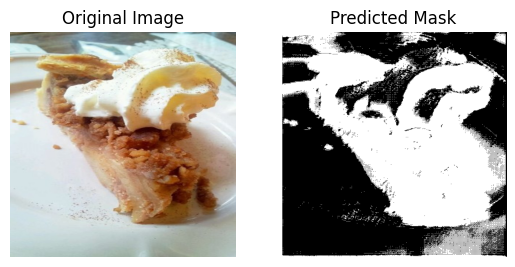

In [46]:
# Threshold the predicted mask to obtain a binary mask
threshold = 0.4
binary_mask = (predicted_mask > threshold).astype(np.uint8)

# Display the original image
plt.subplot(1, 2, 1)
plt.imshow(input_data[0])
plt.title("Original Image")
plt.axis("off")

# Display the predicted binary mask
plt.subplot(1, 2, 2)
plt.imshow(binary_mask[0, :, :, 0], cmap='gray')
plt.title("Predicted Mask")
plt.axis("off")

plt.show()

In [47]:
# Count the number of pixels greater than the threshold (number of ones in the binary mask)
count_greater_than_threshold = np.sum(binary_mask)

print("Number of pixels greater than the threshold:", count_greater_than_threshold)

Number of pixels greater than the threshold: 131619


In [48]:
predicted_mask, input_data = make_prediction('/content/drive/MyDrive/images/apple_pie/LeftOver.jpg')

1/1 [==============================] - 9s 9s/step


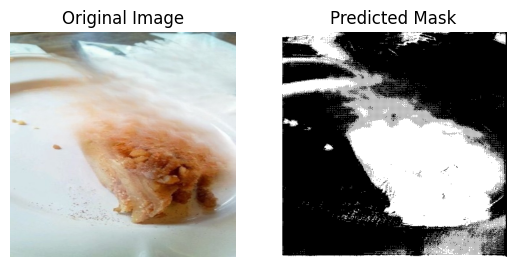

In [49]:
# Threshold the predicted mask to obtain a binary mask
threshold = 0.4
binary_mask = (predicted_mask > threshold).astype(np.uint8)

# Display the original image
plt.subplot(1, 2, 1)
plt.imshow(input_data[0])
plt.title("Original Image")
plt.axis("off")

# Display the predicted binary mask
plt.subplot(1, 2, 2)
plt.imshow(binary_mask[0, :, :, 0], cmap='gray')
plt.title("Predicted Mask")
plt.axis("off")

plt.show()

In [51]:
# Count the number of pixels greater than the threshold (number of ones in the binary mask)
count_greater_than_threshold_leftover = np.sum(binary_mask)

print("Number of pixels greater than the threshold:", count_greater_than_threshold_leftover)

Number of pixels greater than the threshold: 99209


In [57]:
print(f"LeftOver: {round(100 - ((count_greater_than_threshold_leftover*100)/count_greater_than_threshold), 2)}%")

LeftOver: 24.62%


# TO-DO List

This is a collaborative project with 2 people involed in it, as for the remanding subtasks left I'll be delegating to my co-worker:

1. RAM upgrade: The following adjustments had to be done in order to not overload the RAM during the training process:

* Batch size reduced to 50%
* Number of epochs reduced to 6% (As in RAM would take 1 hour per epoch)
* Training images reduced to 15%
* Valid images reduced to 17%
* Fetching option deleted

Re-run the training process from the best point currently avaliable with the original hyperparameter and training set in order to get better results, either Google Colab Pro or locally on a better machine.

2. Train with more food types: The model is currently able to predict food types apple_pie, chicken_wings and other with similar colors, train the model with further types to ensure model adaptability.

3. Define a method that takes an input image and input image leftover and do the whole prediction and calculation process.

4. If it doesn't take more than 2 hours, provide an UI to load original/left-over image and print the results.